In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from collections import OrderedDict


In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### 1. Load and Preprocess the Data

In [4]:
data_dir = 'cat_vs_dog/'
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225]) ])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms=train_transforms)
# test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transforms=test_transforms)

trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
testloader = DataLoader(test_data, batch_size=100)

In [5]:
# check classes
train_data.class_to_idx, test_data.class_to_idx

({'cat': 0, 'dog': 1}, {'cat': 0, 'dog': 1})

<AxesSubplot:>

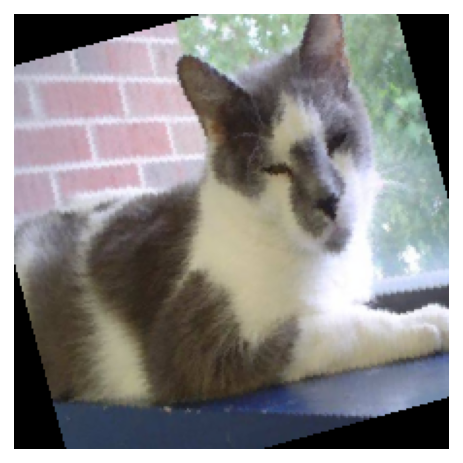

In [6]:
images, labels = next(iter(trainloader))
imshow(images[0])

### 2. Import the Pretrained Model & Check the Name and Shape of the LAST_LAYER_NAME

In [7]:
model = models.densenet121(pretrained=True)
# model = models.alexnet(pretrained=True)
# resnet = models.resnet18(pretrained=True)

# model#, model.features, model.classifier

# 'features' + 'classifier' -> double check the names ('fc' for resnet18)
# when replacing the classifier -> the shape of the 'last layer name' 
# needs to be the same -> in_features=1024 for densenet, 512 for resnet

### 3. Freeze the First Layers with requires_grad=False

In [8]:
# Freeze parameters so we don't backpropagate through them
for param in model.features.parameters():
    param.requires_grad = False

### 4. Define a Classifier that Will Replace the LAST_LAYER_NAME

In [9]:
# # make the input features match

# classifier_test = nn.Sequential(OrderedDict([  ('fc1', nn.Linear(in_features=1024, out_features=2, bias=True))  ]) )
# # OR
# classifier_test = nn.Sequential(nn.Linear(in_features=1024, out_features=2, bias=True))
# # OR
# class Net_test(nn.Module):

#     def __init__(self):
#         super(Net_test, self).__init__()
#         # self.conv1 = nn.Conv2d(3, 64, 5)
#         # self.bn = nn.BatchNorm2d(64)
#         # self.pool = nn.MaxPool2d(2, 2)
#         # self.conv2 = nn.Conv2d(64, 64, 5)
#         self.fc1 = nn.Linear(1024, 128)
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         # x = self.pool(F.relu(self.bn(self.conv1(x))))
#         # x = self.pool(F.relu(self.conv2(x)))
#         # x = x.view(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x)
#         x = self.fc2(x)
#         x = F.dropout(x)
#         x = F.log_softmax(x, dim=1)

#         return x

In [10]:
classifier = nn.Sequential(nn.Linear(in_features=1024, out_features=200, bias=True),
                           nn.ReLU(),
                           nn.Linear(200,2),
                           nn.Softmax(dim=1))

model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

#### Use Cuda to Speed Up the Training Process

In [11]:
torch.cuda.is_available()

False

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 5. Build the Training Loop

In [13]:
criterion = nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 5

start_time = time.time()
for epoch in range(epochs):
    
    model.train()
    for i, (inputs, labels) in enumerate(iter(trainloader)):
        
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            
            with torch.no_grad():
                correct = 0

                model.eval()
                for i, (inputs, labels) in enumerate(iter(testloader)):
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    preds = model(inputs)
                    test_loss += criterion(preds, labels).item()
                    correct += (preds.argmax(1) == labels).type(torch.float).sum().item()

            test_loss /= len(testloader)
            correct /= len(testloader.dataset)
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {(correct*100):.3f}")
            running_loss = 0

    end_time = time.time() - start_time
    print(f"##### Epoch {epoch+1} finished in: {end_time/60} minutes #####")
    # if (epoch+1) % 5 == 0:
    #     torch.save(model.state_dict(), 'checkpoint.pth')


Epoch 1/1.. Train loss: 0.636.. Test loss: 0.016.. Test accuracy: 96.280
Epoch 1/1.. Train loss: 0.380.. Test loss: 0.014.. Test accuracy: 97.920
Epoch 1/1.. Train loss: 0.344.. Test loss: 0.014.. Test accuracy: 96.480
Epoch 1/1.. Train loss: 0.342.. Test loss: 0.013.. Test accuracy: 98.160
Epoch 1/1.. Train loss: 0.348.. Test loss: 0.013.. Test accuracy: 98.440


In [ ]:
# # print("Our model: \n\n", model, '\n')
# # print("The state dict keys: \n\n", model.state_dict().keys())

# # save the state_dict()
# torch.save(model.state_dict(), 'checkpoint.pth')

# # load the state_dict()
# state_dict = torch.load('checkpoint.pth')
# print(state_dict.keys())

# # load the state_dict() into the network
# model.load_state_dict(state_dict)